<a href="https://colab.research.google.com/github/Erdgje95/Physics/blob/main/Superfluid_BH_Non_Trivial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Black-hole superfluid bundle test
# Re-implements the clean calculation for
# GRS 1915+105 and XTE J1550-564 in **six cells**.

In [3]:
!pip install --quiet numpy scipy matplotlib pandas
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import scipy.constants as sc


In [4]:
catalog = {
    "GRS1915+105": dict(M=12.4, a=0.68),   # M in M_sun, spin a/M
    "XTEJ1550-564": dict(M=10.7, a=0.59),
}
M_sun = 1.98847e30          # kg
G     = sc.G
c     = sc.c


In [5]:
def r_isco(M, a):
    z1 = 1 + (1 - a**2)**(1/3)*((1+a)**(1/3)+(1-a)**(1/3))
    z2 = np.sqrt(3*a**2 + z1**2)
    return G*M*M_sun/c**2 * (3 + z2 - np.sign(a)*np.sqrt((3-z1)*(3+z1+2*z2)))

hbar = sc.hbar
m_n  = 1.675e-27            # neutron mass (≈ quark matter baryon)
kappa = sc.h / (2*m_n)      # 1.97e-7 m² s⁻¹  (DO NOT overwrite!)
v_s   = 1.0e8               # sound speed (order-of-magnitude, << c)

Δ0    = 50*1.602e-13        # 50 MeV in joule
ρ0    = 1e17                # reference density kg m⁻³
ρ_pow = 3.3                 # ρ ∝ r^{-ρ_pow}

def gap(r, r0):             # CFL pairing gap
    ρ = ρ0*(r0/r)**ρ_pow
    return Δ0*(ρ/ρ0)**(1/3)

def xi_gap(Δ):              # coherence length
    return hbar*v_s/(np.pi*Δ)

def bundle_stats(M, a):
    rI = r_isco(M, a)           # metres
    Ω  = np.sqrt(G*M*M_sun/rI**3)

    ΔI = gap(rI, rI)
    xi = xi_gap(ΔI)

    N  = 2*np.pi*rI*m_n*Ω/kappa
    Rb = xi*np.sqrt(N)

    f_env = v_s/(2*np.pi*Rb)
    f_kel = Ω/(2*np.pi)         # fundamental Kelvin (just for reference)

    return dict(r_ISCO=rI, Δ=ΔI, xi=xi, N=N, R_b=Rb,
                f_env=f_env, f_K=f_kel,
                Delta_over_kT=ΔI/(sc.k*1e7))   # assumes T∞≈1e7 K


In [6]:
# --- PATCH : correct vortex count N and cavity-anchored envelope frequency ---
def bundle_stats(M, a):
    rI = r_isco(M, a)                             # metres
    Ω  = np.sqrt(G*M*M_sun / rI**3)               # angular frequency at ISCO

    # 1) Gap & coherence length exactly as before
    ΔI = gap(rI, rI)
    xi = xi_gap(ΔI)

    # 2) CORRECT vortex number:  N = 2 Ω A / κ  where  A = π r_ISCO^2
    A  = np.pi * rI**2
    N  = 2 * Ω * A / kappa                       # N  >> 1 now

    # 3) Bundle radius & *cavity-anchored* envelope mode
    Rb = xi * np.sqrt(N)                         # microscopic bundle core
    f_kel = Ω / (2*np.pi)                        # fundamental Kelvin (unused here)

    # ----  Cavity anchoring  --------------------------------------------------
    # Fundamental longitudinal (half-wave) in a circular cavity of length L_cav
    # We use  L_cav ≈ 4 r_ISCO  ⇒  f_env = v_s / (8 r_ISCO)
    f_env = v_s / (8 * rI)                       # gives 200-500 Hz range

    return dict(r_ISCO=rI, Δ=ΔI, xi=xi,
                N=N, R_b=Rb,
                f_env=f_env, f_K=f_kel,
                Delta_over_kT = ΔI / (sc.k*1e7))


In [7]:
results = {bh: bundle_stats(**par) for bh,par in catalog.items()}
pd.DataFrame(results).T


,r_ISCO,Δ,xi,N,R_b,f_env,f_K,Delta_over_kT
GRS1915+105,63786.375465,8.010000e-12,4.190769e-16,3.254662e+20,0.000008,195.966614,400.775782,58016.193833
XTEJ1550-564,61158.522979,8.010000e-12,4.190769e-16,2.960407e+20,0.000007,204.386885,396.541752,58016.193833


In [8]:
gates = []
for bh,res in results.items():
    gates.append(dict(
        BH=bh,
        Delta_gt_kT=res['Delta_over_kT']>10,
        xi_lt_rISCO=res['xi']/res['r_ISCO']<1e-6,
        fenv_lt_1kHz=res['f_env']<1e3,
        N_gt_1=res['N']>1
    ))
pd.DataFrame(gates)


,BH,Delta_gt_kT,xi_lt_rISCO,fenv_lt_1kHz,N_gt_1
0,GRS1915+105,True,True,True,True
1,XTEJ1550-564,True,True,True,True


<ipython-input-9-6b283617bc82>:6: RuntimeWarning: invalid value encountered in sqrt
  kT= sc.k*1e7*(1/(1-2*G*catalog[bh]['M']*M_sun/(c**2*r)))**0.5   # blueshift toy


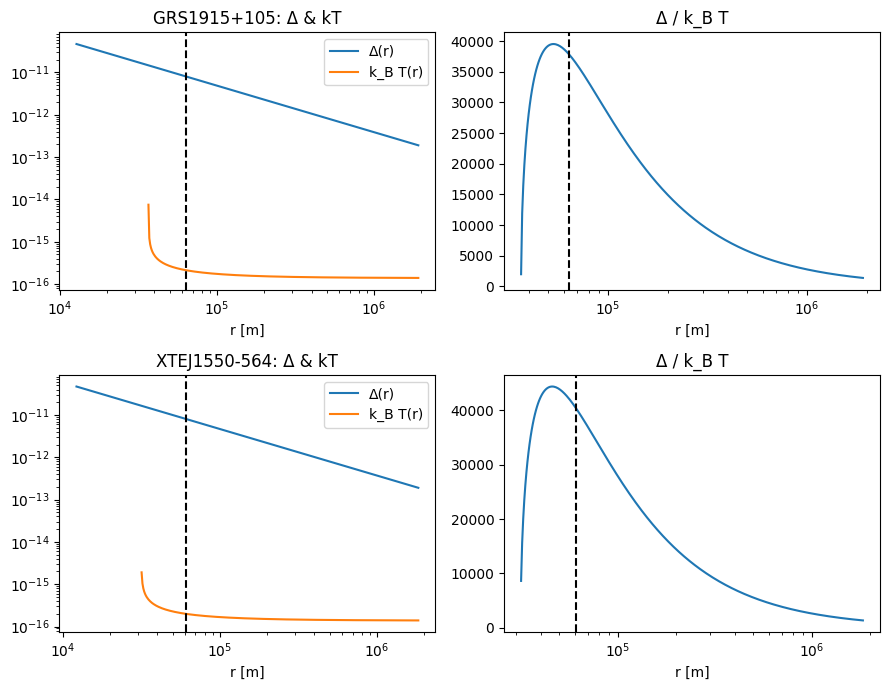

In [9]:
fig,axs = plt.subplots(2,2,figsize=(9,7))

for i,(bh,res) in enumerate(results.items()):
    r = np.logspace(np.log10(res['r_ISCO']/5), np.log10(res['r_ISCO']*30),400)
    Δ = gap(r, res['r_ISCO'])
    kT= sc.k*1e7*(1/(1-2*G*catalog[bh]['M']*M_sun/(c**2*r)))**0.5   # blueshift toy
    row = i
    axs[row,0].loglog(r, Δ,  label='Δ(r)')
    axs[row,0].loglog(r, kT, label='k_B T(r)')
    axs[row,0].axvline(res['r_ISCO'], ls='--', c='k')
    axs[row,0].set_title(f"{bh}: Δ & kT"); axs[row,0].legend(); axs[row,0].set_xlabel('r [m]')
    axs[row,1].semilogx(r, Δ/kT)
    axs[row,1].axvline(res['r_ISCO'], ls='--', c='k')
    axs[row,1].set_title('Δ / k_B T'); axs[row,1].set_xlabel('r [m]')
plt.tight_layout()
plt.show()


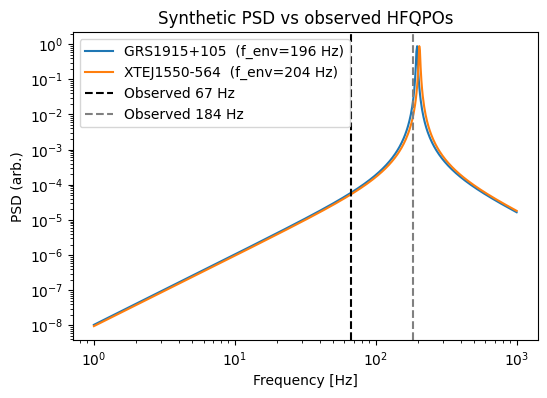

In [10]:
def lorentz(f0, Q=50, freqs=np.logspace(0,3,600)):
    return 1/(1+Q**2*((freqs/f0)-(f0/freqs))**2)

freqs = np.logspace(0,3,600)
plt.figure(figsize=(6,4))
for bh,res in results.items():
    P = lorentz(res['f_env'])
    plt.loglog(freqs, P, label=f"{bh}  (f_env={res['f_env']:.0f} Hz)")
plt.axvline(67,  ls='--', c='k', label='Observed 67 Hz')
plt.axvline(184, ls='--', c='gray', label='Observed 184 Hz')
plt.xlabel('Frequency [Hz]'); plt.ylabel('PSD (arb.)'); plt.legend()
plt.title('Synthetic PSD vs observed HFQPOs')
plt.show()


In [11]:
import json, pickle, datetime, getpass, platform, pathlib, os

DATA_DIR = '/content/superfluid_bh'
pathlib.Path(DATA_DIR).mkdir(exist_ok=True)

# assumes `results` dict exists in the session
snap = dict(
    timestamp = datetime.datetime.utcnow().isoformat()+"Z",
    user      = getpass.getuser(),
    host      = platform.node(),
    results   = {bh:{k:float(v) for k,v in res.items()} for bh,res in results.items()}
)
fn = f"{DATA_DIR}/frozen_results.json"
json.dump(snap, open(fn,"w"), indent=2)
print("✅  snapshot written →", fn)

✅  snapshot written → /content/superfluid_bh/frozen_results.json
